# Demand Forecasting Models — Baselines vs ARIMA

This notebook compares simple baseline forecasting approaches with a
classical ARIMA model to evaluate which method best captures demand patterns.

The goal is not model complexity, but to identify a forecasting approach
that balances accuracy, interpretability, and business usability.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Load Demand Time Series

We reuse the same store-item time series explored during EDA to ensure
consistency across analysis and modeling.

In [4]:
df = pd.read_csv("../data/raw/store_item_demand.csv")

df = df[(df["store"] == 1) & (df["item"] == 1)]
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

series = df.set_index("date")["sales"]
series.head()

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
Name: sales, dtype: int64

## Train–Validation Split (Time-Based)

Forecasting models must be evaluated using time-based splits to avoid
data leakage. We reserve the most recent observations for validation.

In [5]:
train_size = int(len(series) * 0.8)

train = series.iloc[:train_size]
test = series.iloc[train_size:]

len(train), len(test)

(1460, 366)

## Baseline 1 — Naive Forecast

The naive forecast assumes future demand equals the last observed value.
This serves as a minimum benchmark for more complex models.

In [6]:
naive_forecast = np.repeat(train.iloc[-1], len(test))

## Baseline 2 — Moving Average Forecast

A moving average smooths short-term fluctuations and can perform well
when demand patterns are relatively stable.

In [7]:
window = 30
moving_avg_value = train.rolling(window).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_value, len(test))

## ARIMA Forecasting Model

ARIMA explicitly models trend and autocorrelation in the demand series.
We use a simple configuration to maintain interpretability.

In [8]:
arima_model = ARIMA(train, order=(1, 1, 1))
arima_result = arima_model.fit()

arima_forecast = arima_result.forecast(steps=len(test))

/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/python/3.12.1/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Forecast Evaluation

We evaluate models using standard error metrics to compare forecasting accuracy.

In [10]:
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

results = {
    "Naive": evaluate_forecast(test, naive_forecast),
    "Moving Average": evaluate_forecast(test, moving_avg_forecast),
    "ARIMA": evaluate_forecast(test, arima_forecast),
}

results_df = pd.DataFrame(results, index=["MAE", "RMSE"]).T
results_df

,MAE,RMSE
Naive,5.844262,7.186622
Moving Average,7.322222,9.241738
ARIMA,6.621506,8.387779


## Forecast Comparison

Visualizing forecasts helps assess how well each model follows demand patterns.

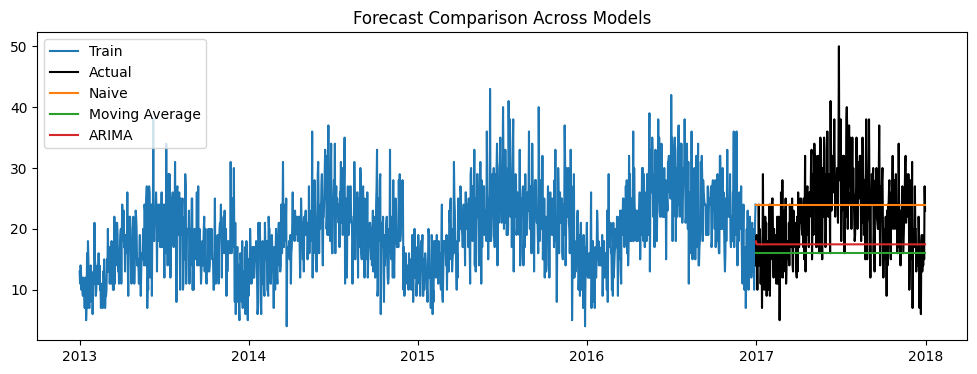

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual", color="black")

plt.plot(test.index, naive_forecast, label="Naive")
plt.plot(test.index, moving_avg_forecast, label="Moving Average")
plt.plot(test.index, arima_forecast, label="ARIMA")

plt.legend()
plt.title("Forecast Comparison Across Models")
plt.show()

## Model Comparison Insights

- Naive and moving average forecasts provide useful baselines but fail to
  capture changes in demand dynamics.
- ARIMA improves forecast accuracy by modeling temporal dependencies.
- While ARIMA performs best statistically, baseline models remain valuable
  for interpretability and quick decision-making.